<a href="https://colab.research.google.com/github/eta-lab/cooling-around/blob/main/models/model_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREAMBLE (ABOUT THIS NOTEBOOK)

This notebook applies data prediction with XGBoost model in Python, on time series (hourly) weather data to predict daily thermal comfort exceedances indoors (e.g., when it gets too hot, and by how much). While this notebook contains only the first steps, ultimately it can help determine how much cooling is needed (in terms of mean radiant temperature or MRT), and ultimately help decide on which cooling technologies are feasible and most carbon efficient.

# IMPORTS

In [ ]:
# Install XGBoost
# ! pip install xgboost # this gives version 0.90
! pip install xgboost==1.4.2 # as of Sept 2021 this is most recent stable release

# import all the usual suspects :)
import os
from google.colab import drive
import pickle
import numpy as np
import pandas as pd
from numpy import array
import matplotlib.pyplot as plt

# Sci-kit learn packages for normalizing data and post-processing
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error, matthews_corrcoef, r2_score, accuracy_score
 
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# boosting libraries from XGBoost
import xgboost as xgb

print("XGBoost version:", xgb.__version__)

     |████████████████████████████████| 166.7 MB 14 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
XGBoost version: 1.4.2


# LOAD THE DATA

The training and testing datasets were pre-processed in a separate notebook saved as separate pickles for 2015,2016 and 2017 (and separated by training and test and output variables based on a prior project) in this public repository:

https://github.com/eta-lab/forecasting-comfort

Details about methods from this project can be found here: Rysanek, A., Nuttall, R., McCarty, J, (2021). Forecasting the impact of climate change on thermal comfort using a weighted ensemble of supervised learning models. Building & Environment.

## MOUNT DRIVE

In [ ]:
# Point to the folder for this project (forecasting-MRT-gap/data)
drive.mount('/content/gdrive')
DATA_PATH = "/content/gdrive/My Drive/Colab Notebooks/forecasting-MRT-gap/data"
FIGURES_PATH = "/content/gdrive/My Drive/Colab Notebooks/forecasting-MRT-gap/figures"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Upload Data and Restrict to Summer/Non-smoky Times

We want temperature data from all three summers, minus the smoky periods (smoke-affected days = when recorded incidences of regional forest fires)

These are respectively the first two weeks of July 2015 and the first two weeks of August 2017

In [ ]:
# 2015

# get training set from another year (so complete for 2015)
df_1 = pickle.load(open(DATA_PATH +'/trainX_2016.pkl','rb'))

# keep only summer dates, e.g., June, July and August:
remove_before = pd.to_datetime('2015-05-23') #*keep last week of May (if available) for lag time
remove_after = pd.to_datetime('2015-08-31')
df_2 = df_1.query('index >= @remove_before and index <= @remove_after')

# drop smoke weeks (first two weeks July 2015) 
start_smoke = pd.to_datetime('2015-07-01')
end_smoke = pd.to_datetime('2015-07-14')
df_3 = df_2.query('index < @start_smoke or index > @end_smoke')

# save 2015 outdoor temps (x variable)
df_2015_X = df_3 



# 2016 

# get training set from another year (so complete for 2016)
df_1 = pickle.load(open(DATA_PATH +'/trainX_2017.pkl','rb'))

# keep only summer dates, e.g., June, July and August:
remove_before = pd.to_datetime('2016-05-23') #*keep last week of May if available  
remove_after = pd.to_datetime('2016-08-31')
df_2 = df_1.query('index >= @remove_before and index <= @remove_after')

# save 2016 outdoor temps (x variable)
df_2016_X = df_2



# 2017

# get training set from another year (so complete for 2017)
df_1 = pickle.load(open(DATA_PATH +'/trainX_2015.pkl','rb'))

# keep only summer dates, e.g., June, July and August:
remove_before = pd.to_datetime('2017-05-23') #*keep last week of May if available  
remove_after = pd.to_datetime('2017-08-31')
df_2 = df_1.query('index >= @remove_before and index <= @remove_after')

# drop smoke weeks (first two weeks July 2015) 
start_smoke = pd.to_datetime('2017-08-01')
end_smoke = pd.to_datetime('2017-07-14')
df_3 = df_2.query('index < @start_smoke or index > @end_smoke')

# save 2017 outdoor temps (x variable)
df_2017_X = df_3

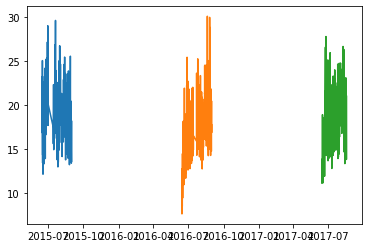

In [ ]:
# plot all outdoor temperatures in cleaned dataset
plt.plot(df_2015_X.index, df_2015_X.temp, df_2016_X.index, df_2016_X.temp, df_2017_X.index, df_2017_X.temp) 
plt.show() 

# SELECT FEATURES

In [ ]:
# keep indoor air temp and relative humidity
df_2015_X = df_2015_X[['temp','last_temp_2','last_temp_4','hum_ratio']]
df_2016_X = df_2016_X[['temp','last_temp_2','last_temp_4','hum_ratio']]
df_2017_X = df_2017_X[['temp','last_temp_2','last_temp_4','hum_ratio']]

## Add feature for previous temperatures

In [ ]:
ls_X = [df_2015_X, df_2016_X, df_2017_X] 

# Add rolling AVERAGE air temp of the PAST 48 hours
def addAverage(df):
    df['temp_ave_48hr'] = df['temp'].rolling(48, min_periods=1).mean() 
    return df 
ls_X2  = [addAverage(df) for df in ls_X]
 

# Add the rolling MAX air temp of the last 24 hours
def addMax(df):
    df['temp_max_24hr'] = df['temp'].rolling(24).max()
    return df 
ls_X3  = [addMax(df) for df in ls_X2]


# Add the rolling MIN air temp of the last 24 hours
def addMin(df):
    df['temp_min_24hr'] = df['temp'].rolling(24).min()
    return df 
ls_X4  = [addMin(df) for df in ls_X3]




ls_X = ls_X4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

## Concatenate 2015, 2016, 2017 into one dataframe

In [ ]:
# save a single dataset with all years
df_all_X = pd.concat(ls_X)

In [47]:
df_all_X

,temp,last_temp_2,last_temp_4,hum_ratio,temp_ave_48hr,temp_max_24hr,temp_min_24hr,day_cos,day_sin
2015-06-15 00:00:00,20.000,21.725,22.950,0.007838,20.000000,NaN,NaN,1.000000,0.000000e+00
2015-06-15 01:00:00,19.500,21.475,22.075,0.006963,19.750000,NaN,NaN,0.965926,2.588190e-01
2015-06-15 02:00:00,19.325,20.000,21.725,0.006424,19.608333,NaN,NaN,0.866025,5.000000e-01
2015-06-15 03:00:00,18.875,19.500,21.475,0.006378,19.425000,NaN,NaN,0.707107,7.071068e-01
2015-06-15 04:00:00,18.150,19.325,20.000,0.006381,19.170000,NaN,NaN,0.500000,8.660254e-01
...,...,...,...,...,...,...,...,...,...
2017-08-18 10:00:00,16.975,14.475,13.950,0.009440,18.650000,22.7,13.825,-0.866025,5.000000e-01
2017-08-18 11:00:00,18.025,15.625,13.825,0.009713,18.638542,22.7,13.825,-0.965926,2.588190e-01
2017-08-18 12:00:00,19.125,16.975,14.475,0.009939,18.613542,22.7,13.825,-1.000000,1.224647e-16
2017-08-18 13:00:00,19.750,18.025,15.625,0.010271,18.590625,22.7,13.825,-0.965926,-2.588190e-01


## Add feature for time of day 

This step adds a variable to help the model understand the cyclicity of the 24 hours cycle
It borrows from the tutorial provided here: https://towardsdatascience.com/single-and-multi-step-temperature-time-series-forecasting-for-vilnius-using-lstm-deep-learning-b9719a0009de

We want the machine to know that hours 23 and 0 are closer to each other than hours 0 and 4. We know that the period of the cycle is 24 hours. We can use the cos(x) and sin(x) functions. The x in the functions is the hour of the day.

In [ ]:
# Extract the hour of day
df_all_X["hour"] = df_all_X.index.hour

# Transform to the cyclical daily feature 
df_all_X["day_cos"] = [np.cos(x * (2 * np.pi / 24)) for x in df_all_X["hour"]]
df_all_X["day_sin"] = [np.sin(x * (2 * np.pi / 24)) for x in df_all_X["hour"]]

# Drop hour of the day as it's own feature
df_all_X.drop('hour', axis=1, inplace=True)

# GET OUTCOME VARIABLE

### GET INDOOR AIR TEMPERATURES FOR SAME TIME SPANS

In [ ]:
#Get raw data of indoor air temps (what we want to predict) 

df1 = pickle.load(open(DATA_PATH +'/trainY_2015.pkl','rb'))
df2 = pickle.load(open(DATA_PATH +'/trainY_2016.pkl','rb'))
df3 = pickle.load(open(DATA_PATH +'/trainY_2017.pkl','rb'))


# Put in all in one place 
ls_Y = [df1, df2, df3]  
df_Y = pd.concat(ls_Y)

# Drop duplicated date-times
df_Y = df_Y[~df_Y.index.duplicated(keep='first')]

# Drop date-times not in X set
df_Y = df_Y[df_Y.index.isin(df_all_X.index)]

# Name column Air Temp Indoors (to distinguish from outdoor or operative indoor)
df_Y = df_Y.to_frame('air_tmp_ind')
df_Y.sort_index(inplace=True)

### CALCULATE HOURLY 'COMFORTABLE' OPERATIVE TEMP INDOORS

The adaptive comfort model's stipulated 'comfortable oeprative temperature' which is defined as a function of the average outdoor air temperature.


Tcomf = 0.31*[Ta,out] + 17.8

where:

Tcomf = indoor comfortable temperature

Ta,out = mean outdoor air temperature*

*mean outdoor temperature as the input variable for the adaptive model. It is based on the arithmetic average of the mean daily outdoor temperatures over no fewer than 7 and no more than 30 sequential days prior. We will use 7.


sources:
ANSI/ASHRAE Standard 55-2017, Thermal Environmental Conditions for Human Occupancy

de Dear, R., & Brager, G. S. (2002). Thermal comfort in naturally ventilated buildings: revisions to ASHRAE Standard 55. Energy and Buildings, 34, 549-561.

In [31]:
# to estimate current comfortable temp, we need the average outdoor air temperature 
df_Y_scratch = df_Y.join(df_all_X['temp']) #join is a left join by default

# merge temp...then get rolling average of previous 7 x 24 hours. 
df_Y_scratch['ave_7days'] = df_Y_scratch['temp'].rolling(168, min_periods=72).mean() 

# Calculate adaptive model comfort temp
df_Y_scratch['op_tmp_comfy'] = 0.31*df_Y_scratch.ave_7days +17.8


### ESTIMATE HOURLY GAP (IF ANY) BETWEEN INDOOR AIR TEMP AND MAX COMFORTABLE OPERATIVE TEMP

The desired 'outcome' is whether the current hour is 'comfortable', based on comparing the indoor air temperature and the adaptive comfort model's stipulated 'comfortable oeprative temperature' (see previous block). 

GAP = op_temp_comfy - op_temp

where

op_temp = 0.5*(air_temp + MRT)

i.e., indoor operative temperature is an average of air temperature and mean radiant temperature, MRT

If the GAP is 0, then:

op_temp_comfy == op_temp

op_temp_comfy == 0.5*(air_temp + MRT)

And re-written to find what the gap is in terms of MRT:

MRT = 2*op_temp_comfy - air_temp

In [33]:
# this is the gap between indoor AIR temp and desired indoor OPERATIVE temp
df_Y_scratch['MRT_comfy'] = 2*df_Y_scratch.op_tmp_comfy - df_Y_scratch.air_tmp_ind 

# this is the MRT, adjusted so it never flips into 'heating' by setting the comfy temp as an MRT 'ceiling' 
cool_enough = df_Y_scratch['op_tmp_comfy']>df_Y_scratch['air_tmp_ind'] 
df_Y_scratch.loc[cool_enough, 'MRT_comfy'] = df_Y_scratch.loc[cool_enough, 'op_tmp_comfy']  # on cool days, set MRT to comfortable operative temp

## Finalize Features and Prediction Target, and Plot some X versus and Y 

In [54]:
# Store the MRT variable as the targetted outcome variable
df_Y_trgt = df_Y_scratch[['MRT_comfy']]
print("predicting: ",df_Y_trgt.columns[0])

# Time stamped features dataframe: df_all_X
print("num of features: ", df_all_X.shape[1])
print("features: ", df_all_X.columns.values)

print("num time points :", df_all_X.shape[0])

predicting:  MRT_comfy
num of features:  9
features:  ['temp' 'last_temp_2' 'last_temp_4' 'hum_ratio' 'temp_ave_48hr'
 'temp_max_24hr' 'temp_min_24hr' 'day_cos' 'day_sin']
num time points : 4632


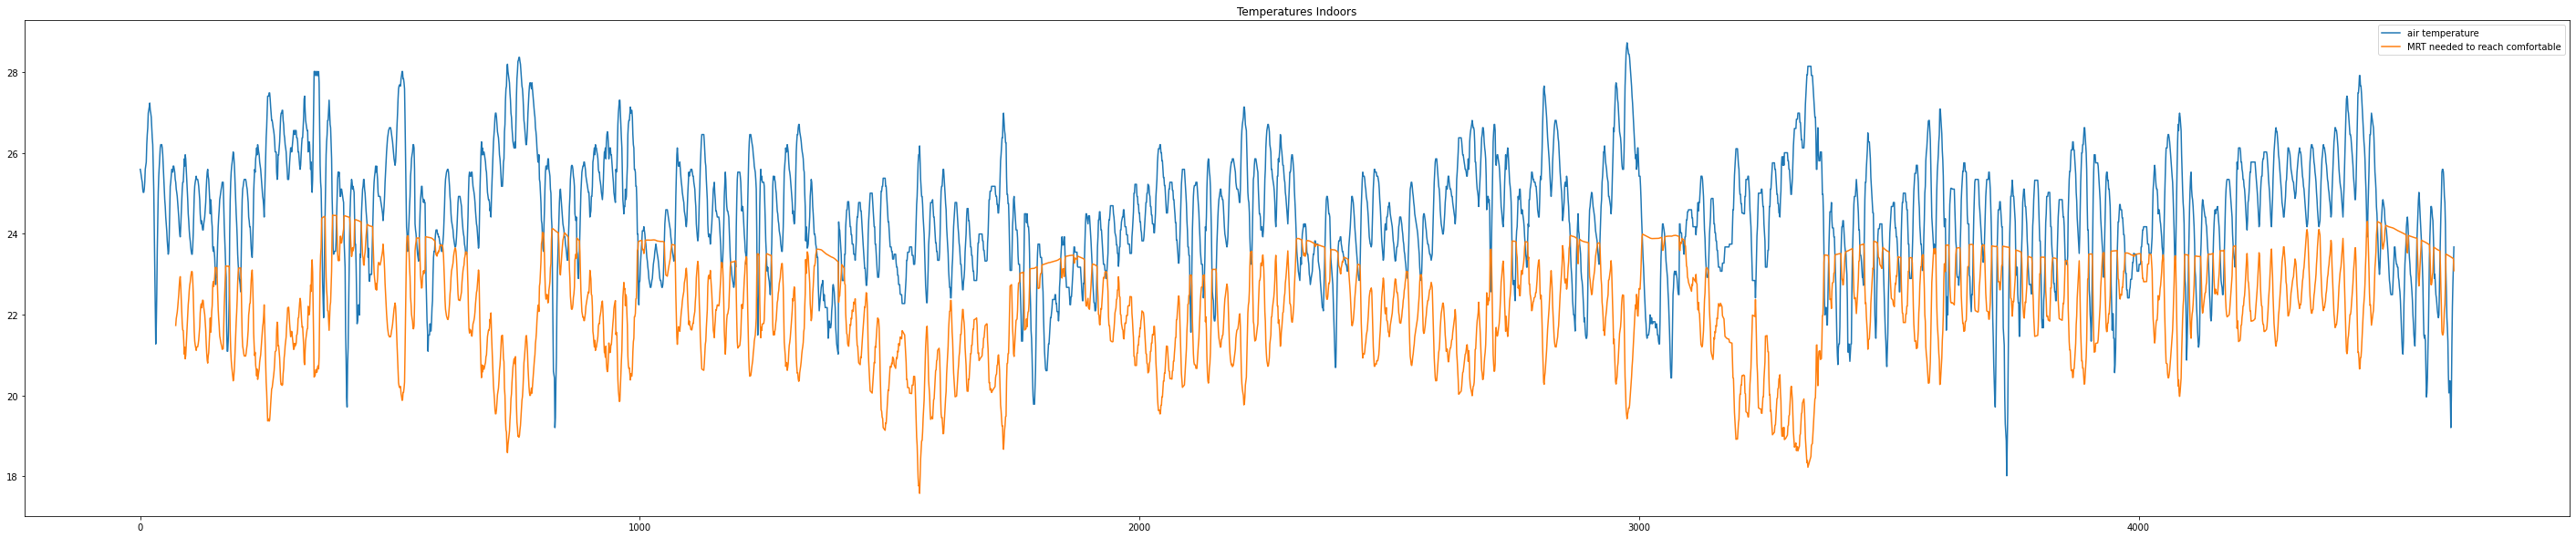

In [55]:
# Visualize the Temperatures (air, comfortable target, required MRT to reach comfortable)
plt.figure(figsize=(50,10))
x_ax = range(len(df_Y_scratch.index))
plt.plot(x_ax,df_Y_scratch.air_tmp_ind, label="air temperature")
#plt.plot(x_ax, df_Y_scratch.op_tmp_comfy, label="comfortable operative temperature")
plt.plot(x_ax, df_Y_trgt.MRT_comfy, label="MRT needed to reach comfortable")
plt.title("Temperatures Indoors")

plt.legend()
plt.show()

# DEFINE and RUN XGBoost MODEL

## Split training and test sets

In [ ]:
x = x_all.copy().to_numpy()
# need to reshape Y which contains 1 features (currently it's 0) 
y = y_all.copy().to_numpy().reshape(-1,1)

# NB split should not be an unordered... (shuffle=False)
x_train, testX, y_train, testY = train_test_split(x, y, shuffle = False, test_size= 0.12)
 
train_dim = (x_train.shape, y_train.shape)
test_dim = (testX.shape, testY.shape)

# check
print("train_dim Xs and Y:", train_dim)
print("test_dim Xs and Y", test_dim)

train_dim Xs and Y: ((4076, 9), (4076, 1))
test_dim Xs and Y ((556, 9), (556, 1))


## OPTIMIZE HYPERPARAMETERS

### Set up parameters (with aim of using HyperOpt to optimize)

Note: 

hp.uniform(label, low, high) — Returns a value uniformly between low and high.

hp.quniform(label, low, high, q) — Returns a value round(uniform(low, high) / q) * q, i.e it rounds the decimal values and returns an integer.

///// Descriptions of parameters: 


n_estimators: The number of trees in the ensemble, often increased until no further improvements are seen.

max_depth: The maximum depth of each tree, often values are between 1 and 10.

eta: The learning rate used to weight each model, often set to small values such as 0.3, 0.1, 0.01, or smaller.

subsample: The number of samples (rows) used in each tree, set to a value between 0 and 1, often 1.0 to use all samples.

colsample_bytree: Number of features (columns) used in each tree, set to a value between 0 and 1, often 1.0 to use all features.

In [ ]:
# Initialize domain space

space={'n_estimators': 180,
       'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'seed': 0
    }

# Pre-sets (won't be tuned by hyperOpt)

# Learning Rate
ETA = 0.01 # range : [0,1] Typical final values : 0.01-0.2

# subsample
SUB = 0.85 # Typical values: 0.5-1 ... Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.


### Define the XGBoost objective function and search hyper-parameter space

In [ ]:

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], 
                    max_depth = int(space['max_depth']), 
                    eta = ETA,
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    subsample = SUB,
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( testX, testY)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,  # objective [default=reg:squarederror]
            eval_metric="mae",
            early_stopping_rounds=10,
            verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }


In [ ]:
# Run some trials...

trials = Trials() # This is a built-in function from HyperOpt

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

## Fit the model with the training data

**** FIX HERE: INSERT BEST HYPER=PARAMETERS ****

In [ ]:

# create an xgboost regression model
model = xgb.XGBRegressor(n_estimators=N_EST, max_depth=MAX_D, eta=ETA, subsample=SUB, colsample_bytree=SMPL_TREE) 

In [ ]:
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, eta=0.01, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.00999999978, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2000, n_jobs=2, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
# Training score
score = model.score(x_train, y_train)  
print("Training score: ", score)

# K-fold cross-validation average score (from sklearn library)
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(model, x_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

Training score:  0.9933846879829399
K-fold CV average score: 0.94


## Predict values (and compare to test set)

MSE: 0.76
RMSE: 0.87


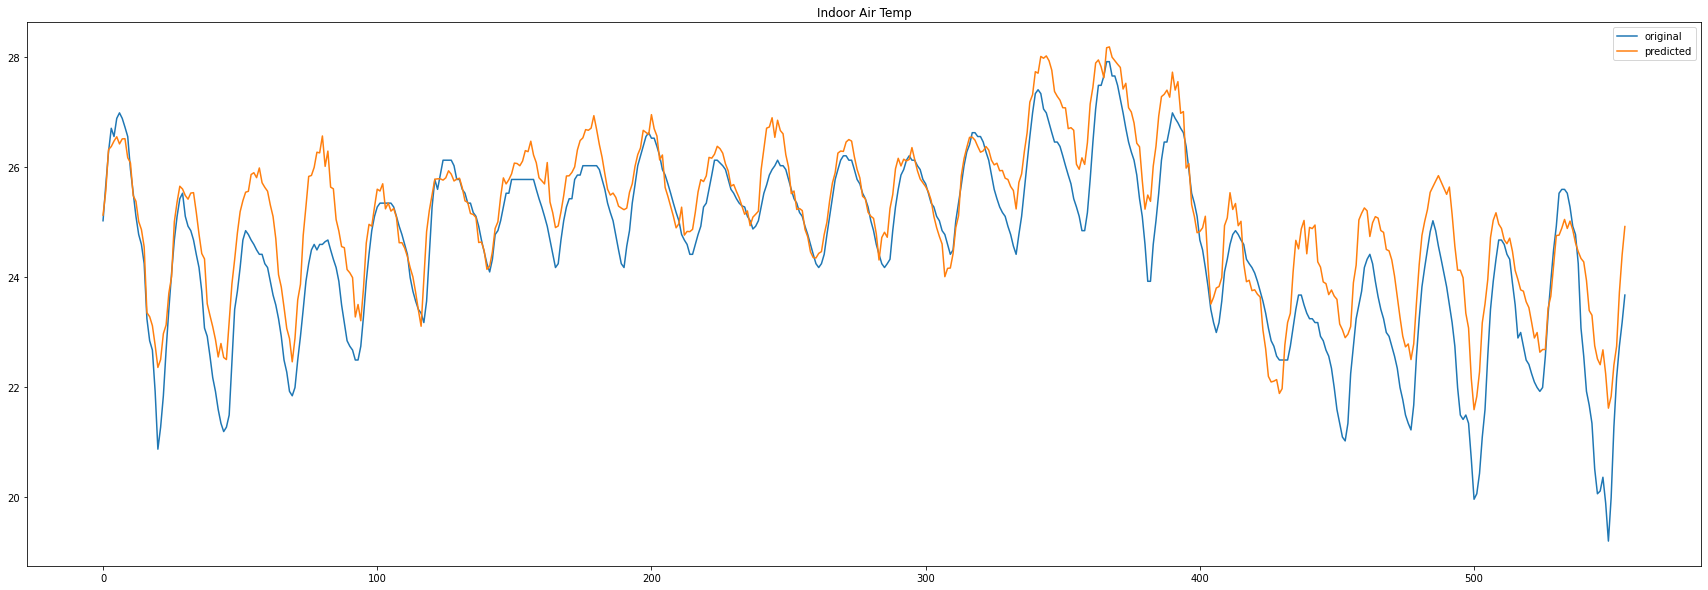

In [ ]:
# Prediction
y_pred = model.predict(testX)

# Calculate Mean Squared Error
mse = mean_squared_error(testY, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

# Visualize Predictions versus Test Set
plt.figure(figsize=(30,10))
x_ax = range(len(testY))
plt.plot(x_ax, testY, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Indoor Air Temp")

plt.legend()
plt.show()

# Sum number of hours that exceed comfort threshold  

